In [1]:
import numpy as np
from scipy import fft, optimize
import NAFFlib as naf
import statistics as st
import matplotlib.pyplot as plt
import time
from IPython.display import display, Math
import re
import csv
from joblib import Parallel, delayed

# BPM Data

In [2]:
#Get data from all BPMs from sdds file
Name_xbpms = []
Name_ybpms = []
Pos_xbpms = np.zeros([1024, 168])
Pos_ybpms = np.zeros([1024, 167])
S_xbpms = np.zeros([1024, 168])
S_ybpms = np.zeros([1024, 167])
with open('data_Wed_Jun_28_20-13-14_2023') as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    init_i = 414
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%168
            
            if (i - init_i)%168 == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < 171423:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%167
            
            if (i - init_i)%167 == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [3]:
# Positions
init_turn = 0 # Starting turn
BPMx = Pos_xbpms.T[:, init_turn:] #np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = Pos_ybpms.T[:, init_turn:] #np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(168, 1024-init_turn)
N_BPMy, _ = np.shape(BPMy) #(167, 1024-init_turn)

#Tunes
Nu_x_meas, Nu_y_meas = 28.235001748, 29.2290029334
nu_x_meas, nu_y_meas = Nu_x_meas%1, Nu_y_meas%1

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

Standard deviation of First Horizontal BPM = 0.08086005371776343


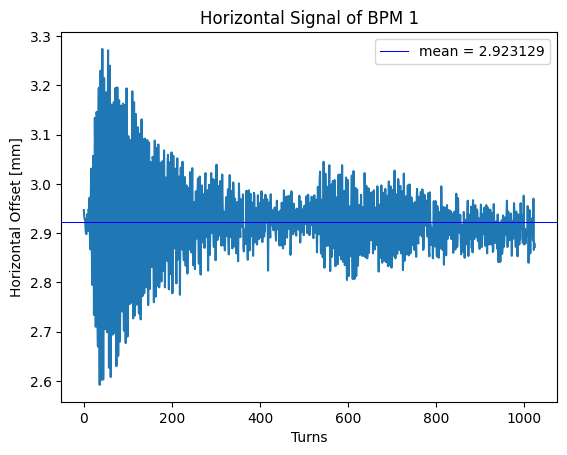

Standard deviation of First Vertical BPM = 0.14039846131415454


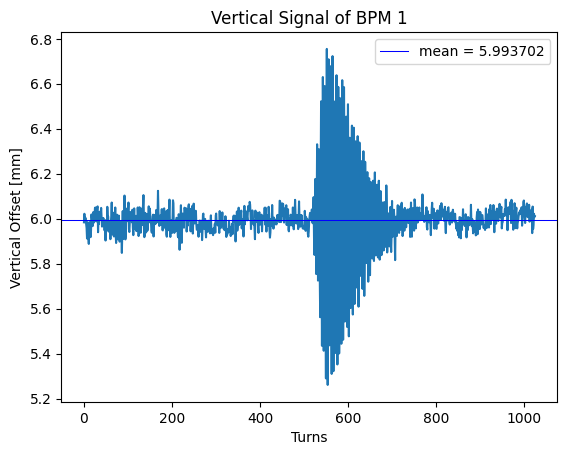

In [4]:
# Look at first BPM Signals
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of First Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("Horizontal Signal of BPM 1")
plt.legend()
plt.show()

BPMy0 = BPMy[0]

BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Standard deviation of First Vertical BPM =", BPMy0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMy0)
plt.axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
plt.xlabel("Turns")
plt.ylabel("Vertical Offset [mm]")
plt.title("Vertical Signal of BPM 1")
plt.legend()
plt.show()

0.23483365949119372


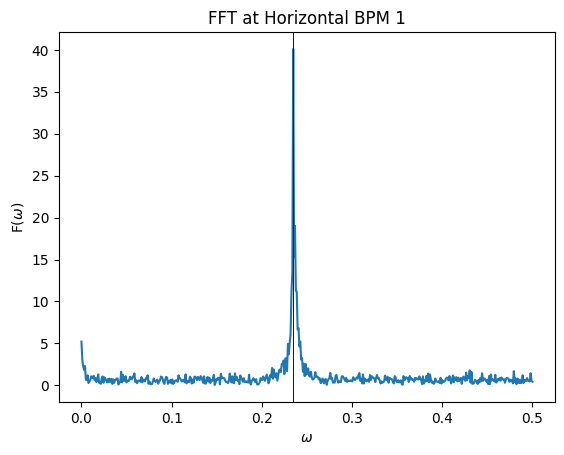

0.22896281800391388


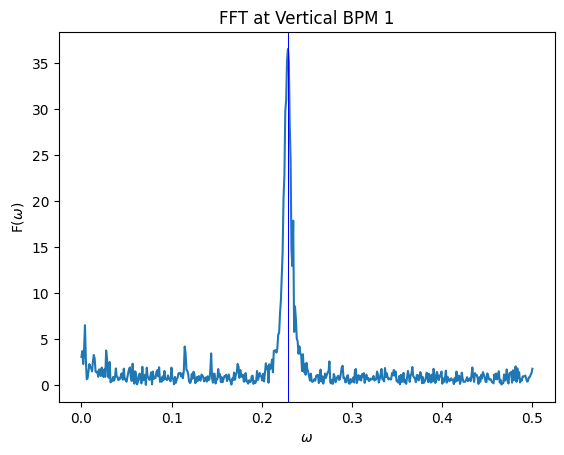

In [5]:
# Look at First BPM FFTs
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
print(BPMx0_Tune_scipy)
plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at Horizontal BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

BPMY0 = np.abs(fft.rfft(BPMy0)[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
print(BPMy0_Tune_scipy)
plt.plot(Omega, BPMY0)
plt.axvline(x = BPMy0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%BPMy0_Tune_scipy)
plt.title("FFT at Vertical BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

0.00016808850880467574 0.0010185889772997558


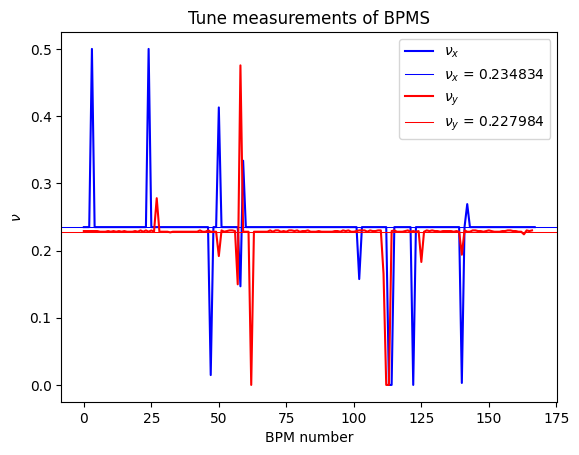

In [6]:
# Look at all FFTs to figure out Tune of machine
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX)]
    # BPM 113 had a flat line

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY)]

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
#Difference from experiment
delta_nu_x, delta_nu_y = abs(nu_x_meas - nu_x), abs(nu_y_meas - nu_y)
print(delta_nu_x, delta_nu_y)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

In [7]:
# Collect bad BPMs
def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > .01:
            Bad_BPM.append(i)
    return Bad_BPM

[11.1800003  -7.84100008]
[11.302      -7.98099995]


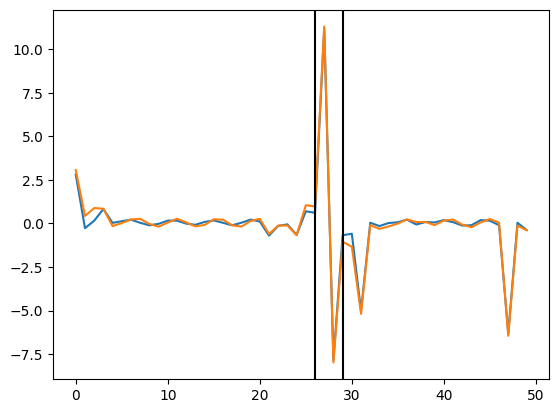

In [8]:
plt.plot(Pos_xbpms[35, :50])
plt.plot(Pos_xbpms[64, :50])
print(Pos_xbpms[35, 27:29])
print(Pos_xbpms[64, 27:29])
plt.axvline(x = 26, color = 'k')
plt.axvline(x = 29, color = 'k')
plt.show()

## Phase Transfer Matrix Calculation

In [9]:
# s points
s_27, s_28 = S_xbpms[0, 27: 29]
sIP8 = 639.445027949618
L_27_28 = s_28 - s_27
print(s_27, s_28, L_27_28)

631.118713 647.771362 16.652648999999997


0.0108120003 0.0109650002 -0.0010995247927221671 -0.0011170595308890496


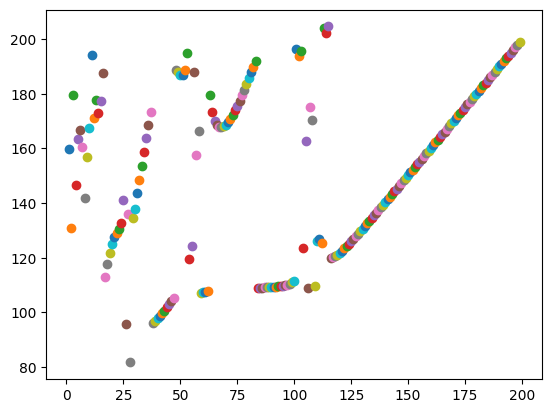

In [17]:
phi = 2*np.pi*nu_x
C = 3834 #m
m_mm = 10**3 # meters to millimeters


def x_final(x, xp, b, a):
    return (np.cos(phi) + a*np.sin(phi))*x + b*np.sin(phi)*xp

def xp_final(x, xp, b, a):
    g = (1 + a**2)/b
    return -g*np.sin(phi)*x + (np.cos(phi) - a*np.sin(phi))*xp

def eps_bpm(x, xp, b, a):
    g = (1 + a**2)/b
    return g*x**2 + 2*a*x*xp + b*xp**2

def epsilon_multi(X, Xp): 
    r = np.mean(X*Xp)/np.sqrt(np.mean(X**2)*np.mean(Xp**2))
    return 4*np.std(X)*np.std(Xp)*np.sqrt(1 - r**2)

x_data27 = BPMx[27]
x_data28 = BPMx[28]
xp_data27 = (x_data28 - x_data27)/L_27_28
eps_init = epsilon_multi(x_data27, xp_data27)

#if i use jac, result becomes too close to guess, if not result goes far from guess
# def jac_func(x, args):
#     b, a, phi = x
#     xi, xf, xpi, xpf = args
#     Jac = [
#         [np.sin(phi)*xpi, np.sin(phi)*xi],
#         [(1 + a**2)/b**2*np.sin(phi)*xi, -2*a/b*np.sin(phi)*xi - np.sin(phi)*xpi]
#     ]
#     return Jac

def func(x, args):
    b, a, eps = x
    xi, xf, xpi, xpf = args
    g = (1 + a**2)/b
    System = [
            #Phase Transfer from current turn to next turn
            xf - x_final(xi, xpi, b, a),
            xpf - xp_final(xi, xpi, b, a),
            eps - eps_bpm(xi, xpi, b, a)]
    
#     print(b, a, System)
#     Sys_vals.append([xs, xps, bs, ss, b0, b, a0, a])
    return System

turn = 555
# x positions at BPM 27
xi_27, xf_27 = BPMx[27, turn: turn + 2]/m_mm

# x positions at BPM 28
xi_28, xf_28 = BPMx[28, turn: turn + 2]/m_mm

# x speed at BPM 27/28 for current turn
xpi_27 = xpi_28 = (xi_28 - xi_27)/L_27_28

# x speed at BPM 27/28 at next turn
xpf_27 = xpf_28 = (xf_28 - xf_27)/L_27_28

# 99.54348468, 99.62958574, 11.87358459, -11.87875497
print(xi_27, xf_27, xpi_27, xpf_27)
Init_var_27 = [100, 12, eps_init]

Args_27 = [[xi_27, xf_27, xpi_27, xpf_27]]
Bounds_27 = (0, np.inf)
# print(optimize.least_squares(func, Init_var_27, bounds = Bounds_27, args = Args_27))
# print(optimize.least_squares(func, Init_var_27, jac = jac_func, bounds = Bounds_27, args = Args_27))
for i in range(1, 200):
    Init_var_27 = [i, 12, eps_init]
    Result27 = optimize.least_squares(func, Init_var_27, bounds = Bounds_27, args = Args_27)
    plt.plot(i, Result27['x'][0], 'o')
plt.show()

# Init_var_28 = [100, -12]
# Args_28 = [[xi_28, xf_28, xpi_28, xpf_28]]
# Bounds_28 = ([0, -np.inf], [np.inf, 0])
# print(optimize.least_squares(func, Init_var_28, jac = jac_func, bounds = Bounds_28, args = Args_28))
# print(optimize.least_squares(func, Init_var_28, bounds = Bounds_28, args = Args_28))


## Linear Regression Calculation

In [18]:
#Linear Regression
from sklearn.linear_model import LinearRegression

In [278]:
initial_turn = 35
interval_turn = 30
x_data27_all = BPMx[27] - np.mean(BPMx[27])
x_data28_all = BPMx[28] - np.mean(BPMx[27])
xp_data27_all = (x_data28_all - x_data27_all)/L_27_28
x_data27 = x_data27_all[initial_turn: initial_turn + interval_turn]
x_data28 = x_data28_all[initial_turn: initial_turn + interval_turn]
xp_data27 = xp_data27_all[initial_turn: initial_turn + interval_turn]

X_data27 = np.array(list(zip(x_data27, xp_data27)))
# y_data27 = np.append(x_data27[1:], x_data27[0])
y_data27 = x_data27_all[initial_turn + 1: initial_turn + interval_turn + 1]

# yp_data27 = np.append(xp_data27[1:], xp_data27[0])
yp_data27 = xp_data27_all[initial_turn + 1: initial_turn + interval_turn + 1]
Y_data27 = np.array(list(zip(y_data27, yp_data27)))
print()
print("Know:")
print(X_data27[:10])
print()

print("Predict:")
print(Y_data27[:10])



Know:
[[ 0.22610867 -1.1422207 ]
 [-0.31589213 -1.07958798]
 [-0.20889173 -1.08631364]
 [ 0.33610837 -1.15375036]
 [ 0.32410827 -1.15020738]
 [-0.24089133 -1.08553301]
 [-0.35989173 -1.07208167]
 [ 0.17910877 -1.13057089]
 [ 0.36510857 -1.15981548]
 [-0.09989153 -1.10018533]]

Predict:
[[-0.31589213 -1.07958798]
 [-0.20889173 -1.08631364]
 [ 0.33610837 -1.15375036]
 [ 0.32410827 -1.15020738]
 [-0.24089133 -1.08553301]
 [-0.35989173 -1.07208167]
 [ 0.17910877 -1.13057089]
 [ 0.36510857 -1.15981548]
 [-0.09989153 -1.10018533]
 [-0.37689193 -1.06799824]]


In [289]:
#LR Calculation:
result = LinearRegression().fit(X_data27, Y_data27)
print(result['coef_'])


#Correlation:
corr = result.score(X_data27, Y_data27)
print(corr)


TypeError: 'LinearRegression' object is not subscriptable

In [280]:
M27 = result.coef_
m11, m12 = M27[0]
m21, m22 = M27[1]
B27 = result.intercept_
b1, b2 = B27
Y_data27_scale = Y_data27 - B27
print("Matrix Elements: ", m11, m12, m21, m22)
print("y-intercepts: ", b1, b2)

Matrix Elements:  5.475111717235314 44.79479644768067 -0.6605386101723519 -5.342632333810022
y-intercepts:  49.910433782255225 -7.066844440386529


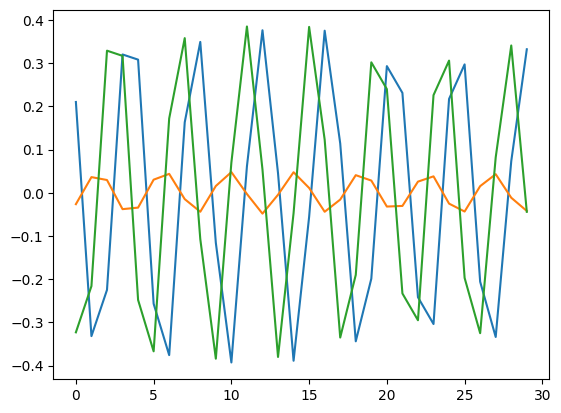

In [281]:
plt.plot(X_data27.T[0] - np.mean(X_data27.T[0]))
plt.plot(X_data27.T[1] - np.mean(X_data27.T[1]))
plt.plot(Y_data27.T[0] - np.mean(Y_data27.T[0]))
plt.show()

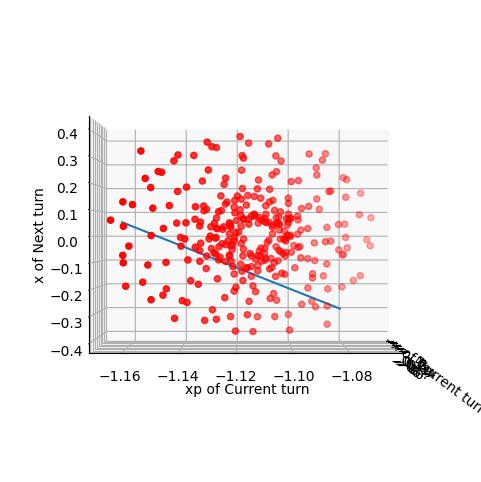

In [276]:
#graph to see correlation between x data and y data:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=0, roll=0)
x_curr = np.linspace(-.4, .4, 100)
xp_curr = np.linspace(-1.08, -1.16, 100)
x_next = (m11*x_curr + m12*xp_curr) + b1

ax.scatter3D(X_data27.T[0], X_data27.T[1], Y_data27.T[0], c ='r', marker = 'o')
ax.plot3D(x_curr, xp_curr, x_next)
ax.set_xlabel('x of Current turn')
ax.set_ylabel('xp of Current turn')
ax.set_zlabel('x of Next turn')
plt.show()

In [290]:
#Twiss at 27
phi27 = np.arccos(m11 + m22)
beta27 = m12/np.sin(phi27)
alpha27 = (m11 - np.cos(phi27))/np.sin(phi27)
print(np.cos(phi27) - alpha27*np.sin(phi27), m22)
print(-(1 + alpha27**2)/beta27*np.sin(phi27), m21)

print(phi27, beta27, alpha27)

-5.210152950384731 -5.342632333810022
-0.6591428426675741 -0.6605386101723519
1.4379263308620054 45.19313957747246 5.390142336175194


## Averages Calculation

In [265]:
x_data27 = (BPMx[27] - np.mean(BPMx[27]))
print(x_data27)
x_data28 = (BPMx[28] - np.mean(BPMx[28]))
print(x_data28)
xp_data27 = (x_data28 - x_data27)/L_27_28
print(xp_data27)

A2 = np.sqrt(np.mean(x_data27**2)*np.mean(x_data28**2) - np.mean(x_data27*x_data28)**2)
print(A2)

b_27, b_28 = L_27_28*np.mean(x_data27**2)/A2, L_27_28*np.mean(x_data28**2)/A2
a_27 = (np.mean(x_data27**2) - np.mean(x_data27*x_data28))/A2
a_28 = -(np.mean(x_data28**2) - np.mean(x_data27*x_data28))/A2
bs, ss = L_27_28/(a_27 - a_28), L_27_28*a_27/(a_27 - a_28)

print(b_27, b_28, a_27, a_28, bs, ss)

[ 0.04210867 -0.00489123  0.01310837 ... -0.04989133 -0.01989163
  0.00810827]
[-0.09388561 -0.07488556 -0.06388588 ...  0.01911431  0.09311419
  0.06511431]
[-0.00816653 -0.0042032  -0.00462354 ...  0.00414382  0.00678606
  0.00342324]
0.0049819967725669954
36.031405050596604 40.95702735882617 4.242552128778571 -4.538338241140007 1.896464743148184 8.045850533196834


[ 0.04210867 -0.00489123  0.01310837 ... -0.04989133 -0.01989163
  0.00810827]
[-0.09388561 -0.07488556 -0.06388588 ...  0.01911431  0.09311419
  0.06511431]
[-0.00816653 -0.0042032  -0.00462354 ...  0.00414382  0.00678606
  0.00342324]
1.2246000188887535e-06


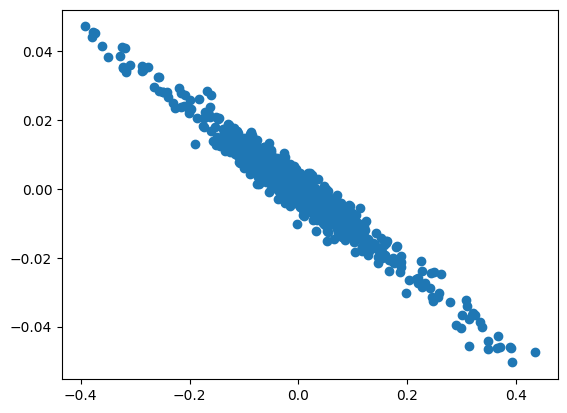

0.10382469303065686
0.01255994305033749
8802.520591737291 10005.856729598876


In [234]:
x_data27 = (BPMx[27] - np.mean(BPMx[27]))
print(x_data27)
x_data28 = (BPMx[28] - np.mean(BPMx[28]))
print(x_data28)
xp_data27 = (x_data28 - x_data27)/L_27_28
print(xp_data27)

eps_init = np.sqrt(np.var(x_data27**2)*np.var(xp_data27**2) - np.var(x_data27*xp_data27)**2)
print(eps_init)

plt.scatter(x_data27, xp_data27)
plt.show()

x_data27_rms = np.sqrt(np.mean(x_data27**2))
x_data28_rms = np.sqrt(np.mean(x_data28**2))
xp_data_rms = np.sqrt(np.mean(xp_data27**2))

print(x_data27_rms)
print(xp_data_rms)

beta_27 = x_data27_rms**2/eps_init
beta_28 = x_data28_rms**2/eps_init
print(beta_27, beta_28)                  


0.010779566882910128 0.012253172340064943
36.031405050596604 40.95702735882617
4.242552128778571 -4.538338241140007
1.896464743148184 8.045850533196834


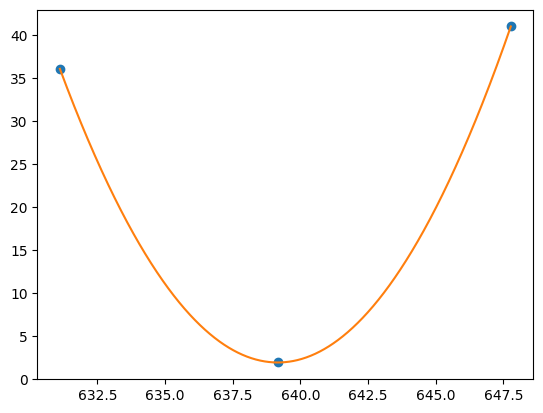

In [97]:
m_mm = 1E3
x_27 = BPMx[27] - np.mean(BPMx[27])
x_28 = BPMx[28] - np.mean(BPMx[28])

x_27_mean2 = np.mean(x_27**2)
x_28_mean2 = np.mean(x_28**2)
print(x_27_mean2, x_28_mean2)
x_27_28_mean = np.mean((x_27*x_28))
A2 = np.sqrt(x_27_mean2*x_28_mean2 - x_27_28_mean**2)

b_27, b_28 = L_27_28*x_27_mean2/A2, L_27_28*x_28_mean2/A2
a_27, a_28 = (x_27_mean2 - x_27_28_mean)/A2, -(x_28_mean2 - x_27_28_mean)/A2
bs, ss = L_27_28/(a_27 - a_28), L_27_28*a_27/(a_27 - a_28)

print(b_27, b_28)
print(a_27, a_28)
print(bs, ss)

      
def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom
    return A,B,C
A, B, C = calc_parabola_vertex(s_27, b_27, s_27 + ss, bs, s_28, b_28)
s_space = np.linspace(s_27, s_28, 1000)
Betatron = A*s_space**2 + B*s_space + C
plt.plot([s_27, s_27 + ss, s_28], [b_27, bs, b_28], 'o')
plt.plot(s_space, Betatron)
plt.show()

## Fitting Normalized Phase Space

[ 4.21086748e-05 -4.89122520e-06  1.31083748e-05 ... -4.98913252e-05
 -1.98916252e-05  8.10827480e-06]
[-9.38856086e-05 -7.48855586e-05 -6.38858786e-05 ...  1.91143114e-05
  9.31141914e-05  6.51143114e-05]
[-8.16652554e-06 -4.20319514e-06 -4.62354388e-06 ...  4.14382340e-06
  6.78605648e-06  3.42324135e-06]


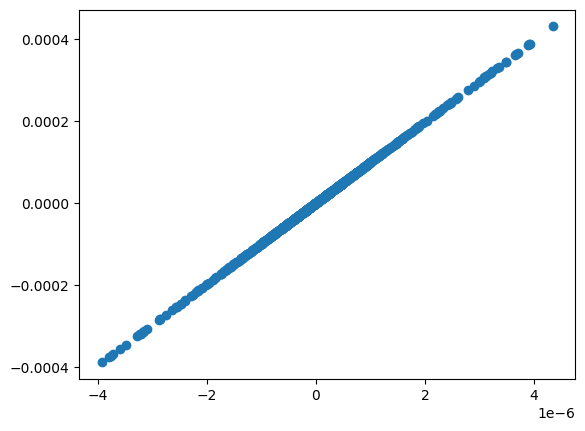

In [201]:
x_data27 = (BPMx[27] - np.mean(BPMx[27]))/m_mm
print(x_data27)
x_data28 = (BPMx[28] - np.mean(BPMx[28]))/m_mm
print(x_data28)
xp_data27 = (x_data28 - x_data27)/L_27_28
print(xp_data27)

beta = 100
alpha = 10
x_data27_norm = x_data27/beta
xp_data27_norm = x_data27 + alpha/beta*xp_data27
plt.scatter(x_data27_norm, xp_data27_norm)
plt.show()


In [117]:
phi = 2*np.pi*nu_x
m_mm = 10**3 # meters to millimeters

N_init = 35
N_interval = 250

# def x_final(x, xp, b0, b, a0):
#     return (np.sqrt(b/b0)*(np.cos(phi) + a0*np.sin(phi))*x 
#             + np.sqrt(b*b0)*np.sin(phi)*xp)
def x_final2(x, xp, b0, b, a0):
    return (  (b/b0) * ((np.cos(phi) + a0*np.sin(phi))*x)**2
            + (b*b0) * (np.sin(phi)*xp)**2
            + 2*b * (np.cos(phi) + a0*np.sin(phi))*x*np.sin(phi)*xp )

# def xp_final(x, xp, b0, b, a0, a):
#     return (1/np.sqrt(b*b0)*((a0 - a)*np.cos(phi) - (1 + a*a0)*np.sin(phi))*x 
#             + np.sqrt(b0/b)*(np.cos(phi) - a*np.sin(phi))*xp)
def xp_final2(x, xp, b0, b, a0, a):
    return (  (1/(b*b0) * (((a0 - a)*np.cos(phi) - (1 + a*a0)*np.sin(phi))*x)**2
            + (b0/b) * ((np.cos(phi) - a*np.sin(phi))*xp)**2
            + 2/b * ((a0 - a)*np.cos(phi) - (1 + a*a0)*np.sin(phi))*x*(np.cos(phi) - a*np.sin(phi))*xp) )

def func(x, args):
    xs, xps, bs, ss, b0, b, a0, a = x
    x_27, x_28, dx = args
    dx_28 = dx_27 = dx
    System = [
            #Phase Transfer from 27 to 28
            x_28**2 - x_final2(x_27, dx_27, b0, b, a0),
            dx_28**2 - xp_final2(x_27, dx_27, b0, b, a0, a),
            
            #Phase Transfer from * to 28
            x_28**2 - x_final2(xs, xps, bs, b, 0),
            dx_28**2 - xp_final2(xs, xps, bs, b, 0, a),
            
            #Phase Transfer from 27 to *
            xs**2 - x_final2(x_27, dx_27, b0, bs, a0),
            xps**2 - xp_final2(x_27, dx_27, b0, bs, a0, 0),
            
            #Twiss Transfer from 27 to *
            bs + (ss - s_27)**2/bs - b0,
            #Twiss Transfer from * to 28
            bs + (s_28 - ss)**2/bs - b]
    
    #print(a0, a)
    #Determinant
#     print((np.cos(phi) + a0*np.sin(phi))*(np.cos(phi) - a*np.sin(phi))
#           - np.sin(phi)*((a0 - a)*np.cos(phi) - (1 + a*a0)*np.sin(phi)))
    Sys_vals.append([xs, xps, bs, ss, b0, b, a0, a])
    return System


def SolveSystem(f, Initial):
    # X_star, Xp_star, beta_star, s_star, beta_27, beta_28, alpha_27, alpha_28
    Unknowns = np.zeros([N_turns, 8])
    Error = np.zeros([N_turns, 8])
    
    i = 0
    for turn in range(N_turns):
        x_27, x_28 = Pos_xbpms[turn, 27: 29]/m_mm
        dx = (x_28 - x_27)/L_27_28
        Args = [x_27, x_28, dx]
        Data = optimize.fsolve(f, Initial, args = Args, full_output = True)
        infodict = Data[1]
        
        Unknowns[i] = Data[0]
        Error[i] = infodict['fvec']

        i += 1
    return Unknowns, Error
        

In [118]:
Sys_vals = []
x_27, x_28 = Pos_xbpms[N_init, 27: 29]/m_mm
dx = (x_28 - x_27)/L_27_28
print("x_27, x_28, dx:")
print(x_27, x_28, dx)
print()

init_vals = [0, dx, 0.5, sIP8, 99.54348468, 99.62958574, 11.87358459, -11.87875497]
Args = [x_27, x_28, dx]

init_res = func(init_vals, Args)
init_err = np.sqrt(np.sum(np.array(init_res)**2))
print("initial function result:", init_res, '\n')
print("initial error:", init_err, '\n')
print("initial results:", optimize.fsolve(func, init_vals, args = Args, full_output = True))


x_27, x_28, dx:
0.0111800003 -0.00784100008 -0.0011422206989410515

initial function result: [-0.0003398021877100824, -3.96166343755902e-06, -2.922100880071166e-06, 3.7434243410465933e-07, -2.0138770375491754e-06, -4.394495456273774e-07, 39.61155660046421, 39.526091697101506] 

initial error: 55.958800391671645 

initial results: (array([ 9.02826407e-04, -1.15574698e-03,  4.51625552e-01,  6.39617320e+02,
        1.60376844e+02,  1.47671831e+02,  1.70237949e+01, -2.04426595e+01]), {'nfev': 307, 'fjac': array([[ 0.00000000e+00,  0.00000000e+00, -9.97712543e-01,
        -1.03161314e-02, -6.68076265e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.15185639e-15,  0.00000000e+00, -6.20660158e-02,
        -1.56871420e-01,  9.51124175e-01,  2.58654154e-01,
         0.00000000e+00,  0.00000000e+00],
       [-2.47095665e-17, -1.53714837e-18, -9.38651633e-12,
         4.62636059e-10,  6.87411147e-11,  2.55571216e-11,
        -7.35809551e-01, -6.77188530e-01],
       [ 1

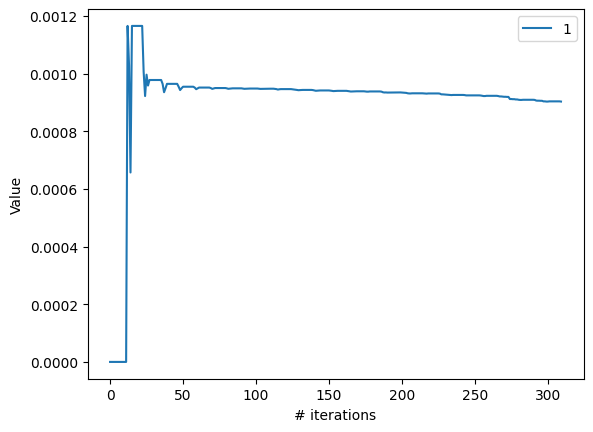

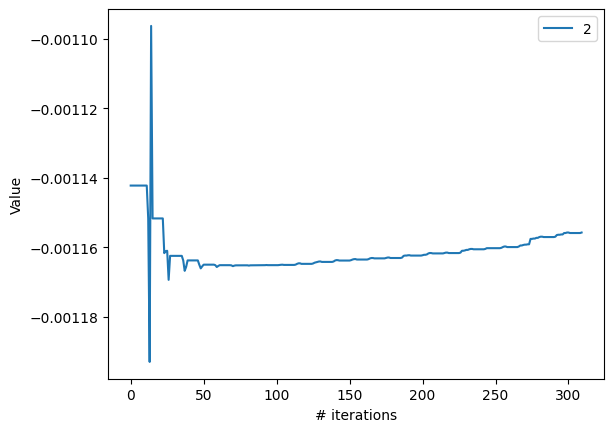

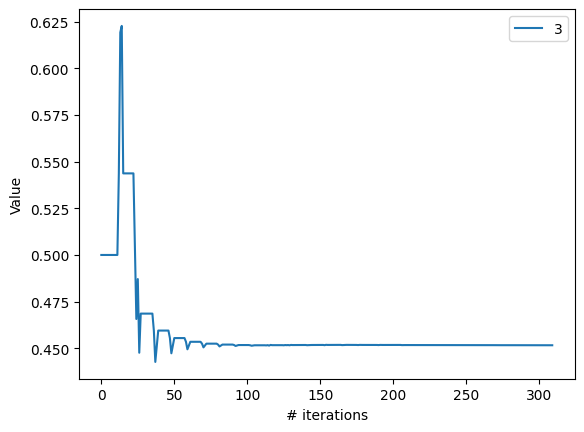

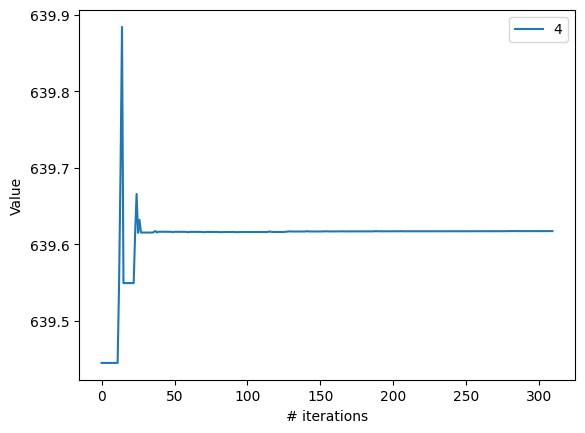

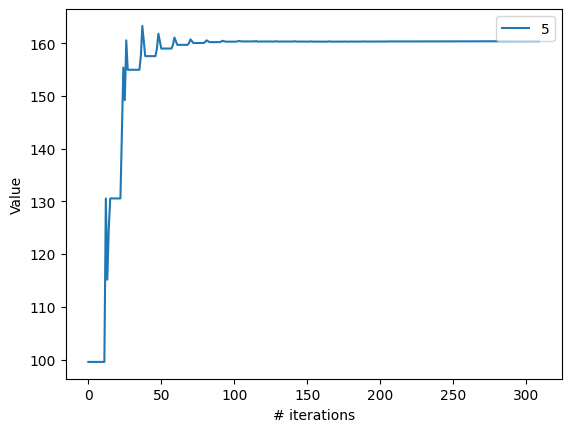

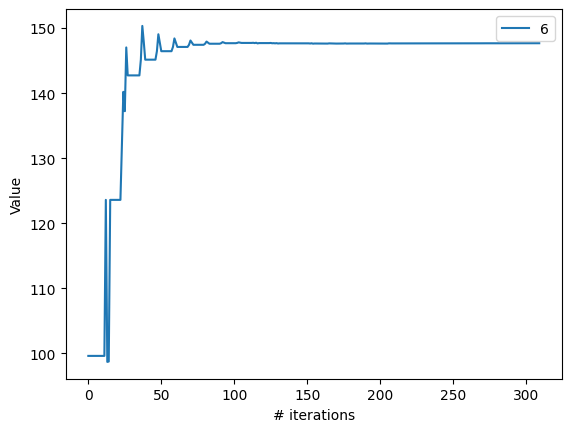

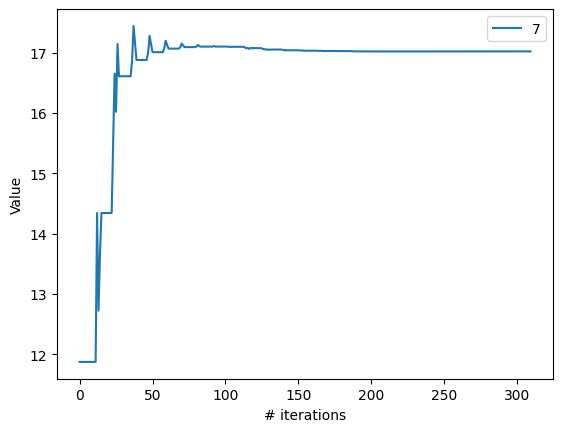

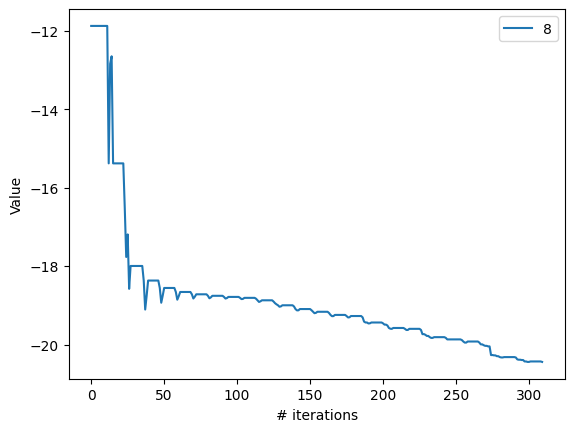

In [119]:
for i in range(8):
    plt.plot((np.array(Sys_vals).T[i]), label = str(i + 1))
    plt.ylabel("Value")
    plt.xlabel("# iterations")
    #plt.yscale("log")
    plt.legend()
    plt.show()

- Fourth and sixth equations increase in error
- Some converge on $Err_i \approx 10^{-6} $, while others oscillate in a periodic fashion, which might be why the program is saying no improvement

- All variables converge for any choice of $\beta^*$

In [85]:
N_beta_star = 199
Beta_star = np.linspace(.1, 1, N_beta_star)

# Mean of data for every beta* guess
Data_mean = np.zeros([N_beta_star, 8])

# Standard deviation of data for every beta* guess
Data_stddev = np.zeros([N_beta_star, 8])

# L2 Error for every beta* guess
Error_mean = np.zeros(N_beta_star)

for i, bs in enumerate(Beta_star):
    #Initial guess from MADx store twiss values
    initial = [0, dx, bs, sIP8, 99.54348468, 99.62958574, 11.87358459, -11.87875497]
    
    Unknown_Data, Error = SolveSystem(func, initial)
    Data_mean[i] = np.mean(Unknown_Data.T, axis = 1)
    Data_stddev[i] = np.std(Unknown_Data.T, axis = 1)
    Error_mean[i] = np.sqrt(np.sum(np.mean(Error.T, axis = 1)**2))
    
print('done')

done


0.8045454545454545
[ 4.35118999e-04 -1.08054027e-03  5.94985327e-01  6.40251248e+02
  1.41509418e+02  9.58897586e+01  1.51363635e+01 -1.40759041e+01]
[2.91327231e-04 1.74013532e-05 3.48153958e-02 1.98893603e-01
 1.26683789e+01 5.26889863e+00 1.35491244e+00 6.97280190e-01]
0.806220008234277


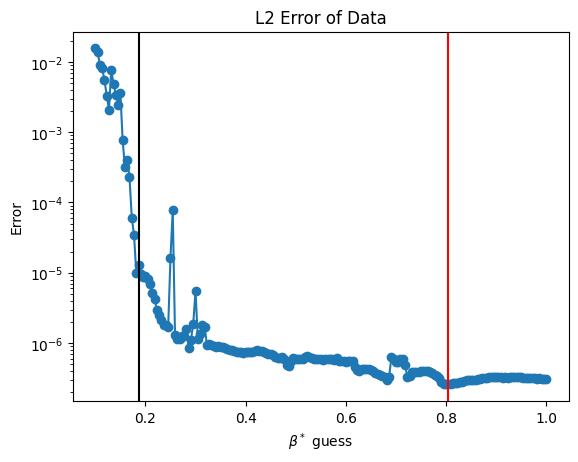

In [138]:
Min_err_index = np.argmin(Error_mean)
print(Beta_star[Min_err_index])
print(Data_mean[Min_err_index])
print(Data_stddev[Min_err_index])
print(Data_mean[Min_err_index][3] - sIP8)

plt.plot(Beta_star, Error_mean, '-o')
plt.title("L2 Error of Data")
plt.xlabel(r"$\beta^*$ guess")
plt.ylabel("Error")
plt.yscale('log')
# plt.xlim(.4, 1)
# plt.ylim(1E-7, 1E-6)
plt.axvline(x = Beta_star[Min_diff_index], color = "k") #comment out
plt.axvline(x = Beta_star[Min_err_index], color = "r")
plt.show()

0.18636363636363637
[ 1.83442271e-03 -1.13885628e-03  4.37495313e-01  6.39538038e+02
  1.64785377e+02  1.59956914e+02  1.58679739e+01 -1.39804062e+01]
[5.44634239e-04 6.04884135e-04 5.54713996e-02 6.38599644e-01
 2.63451193e+01 3.61616286e+01 2.64916687e+00 5.42338033e+00]
0.09300986294772429


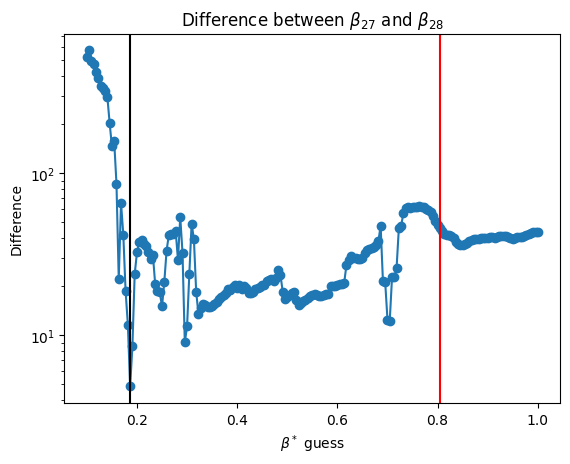

In [104]:
Beta_diff = abs(Data_mean.T[4] - Data_mean.T[5])#*(Data_mean.T[4]/100)
Min_diff_index = np.argmin(Beta_diff)
print(Beta_star[Min_diff_index])
print(Data_mean[Min_diff_index])
print(Data_stddev[Min_diff_index])
print(Data_mean[Min_diff_index][3] - sIP8)

plt.title(r"Difference between $\beta_{27}$ and $\beta_{28}$")
plt.xlabel(r"$\beta^*$ guess")
plt.ylabel("Difference")
plt.plot(Beta_star, Beta_diff, '-o')
plt.yscale("log")
plt.axvline(x = Beta_star[Min_diff_index], color = "k")
plt.axvline(x = Beta_star[Min_err_index], color = "r")
plt.show()

0.6121630382835905


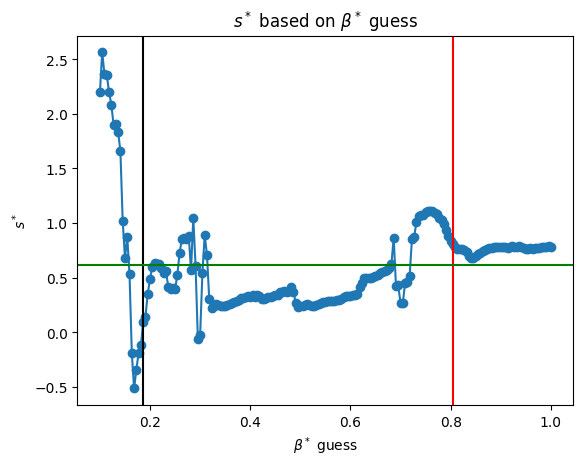

In [139]:
S_star = Data_mean.T[3] - sIP8
S_star_final_avg = np.mean(S_star)
print(S_star_final_avg)

plt.title(r"$s^*$ based on $\beta^*$ guess")
plt.xlabel(r"$\beta^*$ guess")
plt.ylabel("$s^*$")
plt.plot(Beta_star, S_star, '-o')
plt.axvline(x = Beta_star[Min_diff_index], color = "k")
plt.axvline(x = Beta_star[Min_err_index], color = "r")
plt.axhline(y = S_star_final_avg, color = 'g')
plt.show()

0.5462080491852267


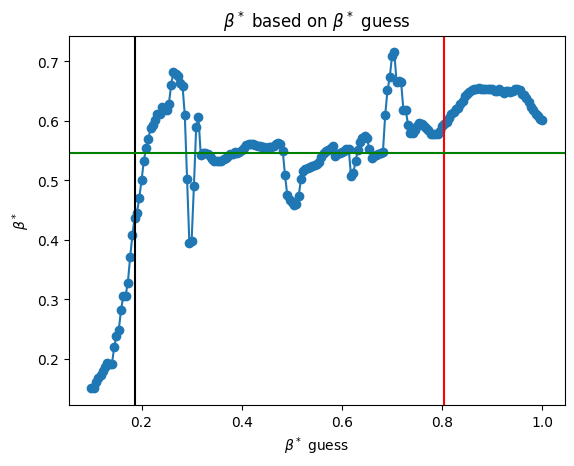

In [110]:
Beta_star_final = Data_mean.T[2]
Beta_star_final_avg = np.mean(Beta_star_final)
print(Beta_star_final_avg)

plt.title(r"$\beta^*$ based on $\beta^*$ guess")
plt.xlabel(r"$\beta^*$ guess")
plt.ylabel(r"$\beta^*$")
plt.plot(Beta_star, Beta_star_final, '-o')
#plt.plot(Beta_star, Beta_star)
plt.axvline(x = Beta_star[Min_diff_index], color = "k")
plt.axvline(x = Beta_star[Min_err_index], color = "r")
plt.axhline(y = Beta_star_final_avg, color = "g")
plt.show()

In [137]:
def func2(x, args):
    b0, b, a0, a = x
    x1_27, x1_28, xp1, x2_27, x2_28, xp2 = args
    xp1_27 = xp1_27 = xp1
    xp2_27 = xp2_28 = xp2
    System = [
            #Phase Transfer from 27 to 28 for one turn
            x1_28**2 - x_final2(x1_27, xp1, b0, b, a0),
            xp1**2 - xp_final2(x1_27, xp1, b0, b, a0, a),
        
            #Phase Transfer from 27 to 28 for another turn
            x2_28**2 - x_final2(x2_27, xp2, b0, b, a0),
            xp2**2 - xp_final2(x2_27, xp2, b0, b, a0, a),
    ]
    
#     print((np.cos(phi) + a0*np.sin(phi))*(np.cos(phi) - a*np.sin(phi))
#           - np.sin(phi)*((a0 - a)*np.cos(phi) - (1 + a*a0)*np.sin(phi)))
    print(b0, b, a0, a, System)
    return System
    
    
initial2 = [99.54348468, 99.62958574, 11.87358459, -11.87875497]

x1_27, x1_28 = Pos_xbpms[35, 27: 29]/m_mm
xp1 = (x1_28 - x1_27)/L_27_28

x2_27, x2_28 = Pos_xbpms[36, 27: 29]/m_mm
xp2 = (x2_28 - x2_27)/L_27_28

Args2 = [x1_27, x1_28, xp1, x2_27, x2_28, xp2]
print(optimize.fsolve(func2, initial2, args = Args2, full_output = True))

iterations = 0
Max_iterations = 100000
Final = np.zeros(4)
# for i in range(N_turns):
#     for j in range(N_turns):
#         if iterations > Max_iterations: break
#         x1_27, x1_28 = Pos_xbpms[i, 27: 29]/m_mm
#         xp1 = (x1_28 - x1_27)/L_27_28
            
#         x2_27, x2_28 = Pos_xbpms[j, 27: 29]/m_mm
#         xp2 = (x2_28 - x2_27)/L_27_28
        
#         Args2 = [x1_27, x1_28, xp1, x2_27, x2_28, xp2]
#         Final += optimize.fsolve(func2, initial2, args = Args2)#, full_output = True)
        
#         iterations += 1
        

# print(Final/Max_iterations)     


99.54348468 99.62958574 11.87358459 -11.87875497 [-0.0003398021877100824, -3.96166343755902e-06, -0.0003373917752565096, -3.987748618835511e-06]
99.54348468 99.62958574 11.87358459 -11.87875497 [-0.0003398021877100824, -3.96166343755902e-06, -0.0003373917752565096, -3.987748618835511e-06]
99.54348468 99.62958574 11.87358459 -11.87875497 [-0.0003398021877100824, -3.96166343755902e-06, -0.0003373917752565096, -3.987748618835511e-06]
99.54348616331352 99.62958574 11.87358459 -11.87875497 [-0.0003398021141297496, -3.961662428313002e-06, -0.0003373917063346969, -3.987747671808061e-06]
99.54348468 99.6295872245965 11.87358459 -11.87875497 [-0.0003398021936896777, -3.961663359084575e-06, -0.00033739178108684926, -3.9877485420460245e-06]
99.54348468 99.62958574 11.873584766930199 -11.87875497 [-0.0003398022666346715, -3.96166452424472e-06, -0.00033739184941171586, -3.987749641678508e-06]
99.54348468 99.62958574 11.87358459 -11.878754792992757 [-0.0003398021877100824, -3.96166327421144e-06, -0.

## Averages Calculation

$\mathcal{A}^2 = \sqrt{\langle x_{27}^2 \rangle \langle x_{28}^2 \rangle - \langle x_{27} x_{28} \rangle^2}$\
$\beta_1 = \frac{L\langle x_{27} \rangle}{\mathcal{A}^2}$\
$\beta_2 = \frac{L\langle x_{28} \rangle}{\mathcal{A}^2}$

$\alpha_1 = \frac{\langle x_{27}^2 \rangle  - \langle x_{27} x_{28} \rangle}{\mathcal{A}^2}$\
$\alpha_2 = \frac{\langle x_{28}^2 \rangle - \langle x_{27} x_{28} \rangle}{\mathcal{A}^2}$

$\beta^* = \frac{L}{\alpha_1 - \alpha_2}$\
$s^* = \frac{L\alpha_1}{\alpha_1 - \alpha_2}$

This method doesn't work as well since $|x_{27}^2|$ is half of $|x_{28}^2|$, which means that $\beta_{27}$ will not be close to $\beta_{28}$.

0.00011999852130340692 5.765245213103308e-05
3289.7108737066633 1580.5186314902342
334.47412297471135 -231.83626384392502
0.029405515751794054 9.835384091700375


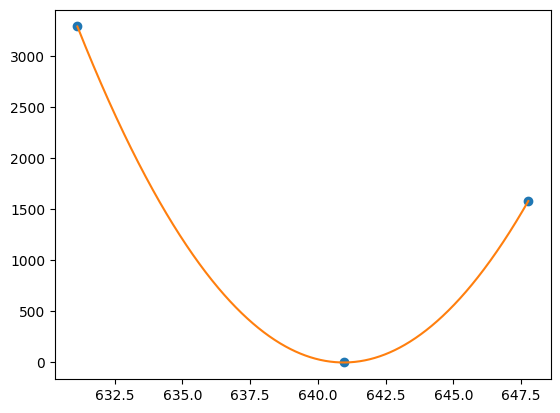

In [14]:
m_mm = 1E3
x_27 = BPMx[27]/m_mm
x_28 = BPMx[28]/m_mm

x_27_mean2 = np.mean(x_27**2)
x_28_mean2 = np.mean(x_28**2)
print(x_27_mean2, x_28_mean2)
x_27_28_mean = np.mean((x_27*x_28))
A2 = np.sqrt(x_27_mean2*x_28_mean2 - x_27_28_mean**2)

b_27, b_28 = L_27_28*x_27_mean2/A2, L_27_28*x_28_mean2/A2
a_27, a_28 = (x_27_mean2 - x_27_28_mean)/A2, -(x_28_mean2 - x_27_28_mean)/A2
bs, ss = L_27_28/(a_27 - a_28), L_27_28*a_27/(a_27 - a_28)

print(b_27, b_28)
print(a_27, a_28)
print(bs, ss)

      
def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom
    return A,B,C
A, B, C = calc_parabola_vertex(s_27, b_27, s_27 + ss, bs, s_28, b_28)
s_space = np.linspace(s_27, s_28, 1000)
Betatron = A*s_space**2 + B*s_space + C
plt.plot([s_27, s_27 + ss, s_28], [b_27, bs, b_28], 'o')
plt.plot(s_space, Betatron)
plt.show()